In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier
import operator
%matplotlib inline

In [31]:
def heat_conf(conf_matrix):
    fig = plt.figure(figsize=(8,8))
    # plotting the heatmap
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(conf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    ax.set_ylim(len(conf_matrix)+1, -1)
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [5]:
train_df = pd.read_csv(r"C:\Users\Notebook HP\Desktop\fds project\version41.csv")

In [6]:
train_df

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,app_PRODUCT_COMBINATION_Cash X-Sell: middle,app_PRODUCT_COMBINATION_POS household with interest,app_PRODUCT_COMBINATION_POS household without interest,app_PRODUCT_COMBINATION_POS industry with interest,app_PRODUCT_COMBINATION_POS industry without interest,app_PRODUCT_COMBINATION_POS mobile with interest,app_PRODUCT_COMBINATION_POS mobile without interest,app_PRODUCT_COMBINATION_POS other with interest,app_PRODUCT_COMBINATION_POS others without interest,app_pre_app_count
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,...,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,1.0
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,...,0.00,0.333333,0.0,0.333333,0.0,0.000000,0.0,0.0,0.0,3.0
2,100004,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,...,0.00,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.0,0.0,1.0
3,100006,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,...,0.00,0.111111,0.0,0.111111,0.0,0.000000,0.0,0.0,0.0,9.0
4,100007,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,...,0.50,0.166667,0.0,0.000000,0.0,0.166667,0.0,0.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,-236,-8456.0,...,0.00,0.000000,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,1.0
307507,456252,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,365243,-4388.0,...,0.00,0.000000,1.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0
307508,456253,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,-7921,-6737.0,...,0.00,0.000000,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,2.0
307509,456254,0,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,-4786,-2562.0,...,0.00,0.500000,0.0,0.000000,0.0,0.500000,0.0,0.0,0.0,2.0


### Adding some useful features

In [7]:
train_df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True) # Deleting outsiders

In [8]:
train_df['CREDIT_DIV_ANNUITY'] = train_df['AMT_CREDIT']/train_df['AMT_ANNUITY']

In [9]:
train_df['ANNUITY_INCOME_PERCENT'] = train_df['AMT_ANNUITY'] / train_df['AMT_INCOME_TOTAL']

In [10]:
train_df['BIRTH_DIV_EMPLOYED'] = train_df['DAYS_BIRTH']/train_df['DAYS_EMPLOYED']

In [11]:
train_df['DAYREG_DIV_DAYPUB'] = train_df['DAYS_REGISTRATION']/train_df['DAYS_ID_PUBLISH']

In [12]:
train_df['CREDIT_MINUS_GOOD'] = train_df['AMT_CREDIT']/train_df['AMT_GOODS_PRICE']

In [13]:
train_df['INCOME_CHILD'] = train_df['AMT_INCOME_TOTAL']/train_df['CNT_CHILDREN']

In [14]:
train_df['INCOME_DIV_FAM'] = train_df['AMT_INCOME_TOTAL']/train_df['CNT_FAM_MEMBERS']

In [15]:
train_df['INTEREST'] = train_df['app_CNT_PAYMENT']*train_df['AMT_ANNUITY'] - train_df['AMT_CREDIT']

In [16]:
train_df['INTEREST_RATE'] = 2*12*train_df['INTEREST']/(train_df['AMT_CREDIT']*(train_df['app_CNT_PAYMENT']+1))

In [17]:
train_df['INTEREST_SHARE'] = train_df['INTEREST']/train_df['AMT_CREDIT']

#### Checking for Nan, inf or -inf values and substituding them with the mean of each numeric columns

In [18]:
# Substituting inf and -inf values with nan
train_df = train_df.replace([np.inf, -np.inf], np.nan)

In [19]:
# Filling the Nan values in the new numeric columns with the mean
for column in list(train_df.columns):
    if train_df[column].dtypes == 'float64':
        train_df[column] = train_df[column].fillna(train_df[column].mean())

In [20]:
# Checking if there are still any problems into the dataframe
train_df.isnull().any().any()

False

---

In [21]:
# Selecting the 'SK_ID_CURR' column for future use
client_names = train_df[['SK_ID_CURR']]
client_names

,SK_ID_CURR
0,100002
1,100003
2,100004
3,100006
4,100007
...,...
307506,456251
307507,456252
307508,456253
307509,456254


In [22]:
# Splitting dataframe in features and target variable
feature_cols = list(train_df.columns)
y = train_df.TARGET.values # Target variable
train_df = train_df[feature_cols].drop(['TARGET'], axis = 1) 
train_df = train_df.drop(['SK_ID_CURR'], axis = 1) # Features


#### Dividing the data into train, val and test datasets

Now that we have defined the initial dataframe of features and the Target variable array, we can divide our dataset into training, validation and testing sets, and then select suitable methods for binary classification in order to develop our statistical model.

In [23]:
# Splitting the dataset
X_train, X_temp, y_train, y_temp = train_test_split(train_df, y, stratify = y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify = y_temp, test_size=0.5, random_state=42)

print('Shape of X_train:',X_train.shape)
print('Shape of X_val:',X_val.shape)
print('Shape of X_test:',X_test.shape)

Shape of X_train: (215257, 506)
Shape of X_val: (46127, 506)
Shape of X_test: (46127, 506)


As we can see, we can count over 500 columns in our dataframes, and so many different features can consistently slow our models and generate too much noise, so that becomes even more difficult finding the correct probability that each client will or won't pay back the loan.

For these reasons, we already decided to select the best feature with light gbm

In [24]:
model_sel = lgb.LGBMClassifier(boosting_type='gbdt', max_depth=7, learning_rate=0.01, n_estimators= 2000, 
                 class_weight='balanced', subsample=0.9, colsample_bytree= 0.8, n_jobs=-1)
train_features, valid_features, train_y, valid_y = train_test_split(X_train, y_train, test_size = 0.15, random_state = 42)
model_sel.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], eval_metric = 'auc', verbose = 200)

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.756421	valid_0's binary_logloss: 0.590982
[400]	valid_0's auc: 0.770388	valid_0's binary_logloss: 0.563871
[600]	valid_0's auc: 0.776057	valid_0's binary_logloss: 0.549486
[800]	valid_0's auc: 0.778801	valid_0's binary_logloss: 0.539544
[1000]	valid_0's auc: 0.780082	valid_0's binary_logloss: 0.531793
[1200]	valid_0's auc: 0.780624	valid_0's binary_logloss: 0.525166
[1400]	valid_0's auc: 0.78081	valid_0's binary_logloss: 0.519461
Early stopping, best iteration is:
[1423]	valid_0's auc: 0.780912	valid_0's binary_logloss: 0.518746


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=0.8, importance_type='split',
               learning_rate=0.01, max_depth=7, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=2000,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.9,
               subsample_for_bin=200000, subsample_freq=0)

In [25]:
get_feat = pd.DataFrame(sorted(zip(model_sel.feature_importances_, train_df.columns)), columns=['Value','Feature'])
features_sorted = get_feat.sort_values(by="Value", ascending=False)
features_sel = list(features_sorted[features_sorted['Value']>=50]['Feature'])

In [30]:
print(features_sel, len(features_sel))

['CREDIT_DIV_ANNUITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'CREDIT_MINUS_GOOD', 'DAYS_EMPLOYED', 'AMT_ANNUITY', 'ins_PAYMENT_DIFF', 'POS_CNT_INSTALMENT_FUTURE', 'ANNUITY_INCOME_PERCENT', 'DAYS_ID_PUBLISH', 'BUR_AMT_CREDIT_SUM_DEBT', 'app_CNT_PAYMENT', 'app_AMT_ANNUITY', 'POS_prev_pos_count', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'ins_DBD', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION', 'app_AMT_DOWN_PAYMENT', 'BUR_AMT_CREDIT_MAX_OVERDUE', 'BIRTH_DIV_EMPLOYED', 'BUR_AMT_CREDIT_SUM', 'ins_CNT_DRAWINGS_ATM_CURRENT', 'REGION_POPULATION_RELATIVE', 'ins_AMT_PAYMENT', 'ins_NUM_INSTALMENT_VERSION', 'BUR_DAYS_CREDIT_ENDDATE', 'BUR_Loan_FRQ', 'BUR_DAYS_CREDIT', 'app_NAME_CONTRACT_STATUS_Refused', 'OWN_CAR_AGE', 'ins_NUM_INSTALMENT_NUMBER', 'ins_ins_count', 'ins_PAYMENT_PERC', 'INTEREST', 'app_HOUR_APPR_PROCESS_START', 'POS_SK_DPD_DEF', 'app_SELLERPLACE_AREA', 'app_NAME_YIELD_GROUP_high', 'POS_MONTHS_BALANCE', 'DAYREG_DIV_DAYPUB', 'BUR_CREDIT_ACTIVE_Closed', 'CODE_GENDER_F', 

In [28]:
# Selecting the best 150 features out of 202
best_features = features_sel[0:150]

In [32]:
# Defining new dataframes with only the selected features
X_train_sel = X_train[features_sel]
X_val_sel = X_val[features_sel]
X_test_sel = X_test[features_sel]

In [33]:
X_train_best = X_train_sel[best_features]
X_test_best = X_test_sel[best_features]
X_val_best = X_val_sel[best_features]

In [34]:
# Feature Scaling
sc = StandardScaler()
X_train_sel = sc.fit_transform(X_train_sel)
X_train_sel = sc.transform(X_train_sel)
X_test_sel = sc.fit_transform(X_test_sel)
X_test_sel = sc.transform(X_test_sel)
X_val_sel = sc.fit_transform(X_val_sel)
X_val_sel = sc.transform(X_val_sel)


In [35]:
X_train_best = sc.fit_transform(X_train_best)
X_train_best = sc.transform(X_train_best)
X_test_best = sc.fit_transform(X_test_best)
X_test_best = sc.transform(X_test_best)
X_val_best = sc.fit_transform(X_val_best)
X_val_best = sc.transform(X_val_best)

### Logistic Regression

In [36]:
aucs = {}

In [37]:
# inizialize the model (using the default parameters)
logistic = LogisticRegression(max_iter = 4000) # It doesn't converge for lower values

# fit the model with data
logistic.fit(X_train_best,y_train)

# Predicting the target values for X_test
y_pred = logistic.predict(X_test_best)

C:\Users\Notebook HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Defining and plotting with heatmap the confusion matrix relative to logistic regression

In [38]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

<Figure size 576x576 with 0 Axes>

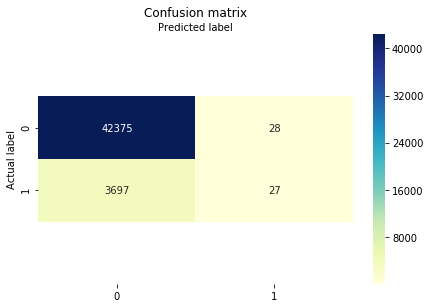

In [39]:
heat_conf(conf_matrix)

Let's see the Accuracy, Precision and Recall values:

In [40]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, pos_label = 1))
print("Recall:",metrics.recall_score(y_test, y_pred, pos_label = 1))

Accuracy: 0.9192446939970083
Precision: 0.4909090909090909
Recall: 0.007250268528464017


Now we can plot the ROC, and calculate the AUC relative to logistic regression.

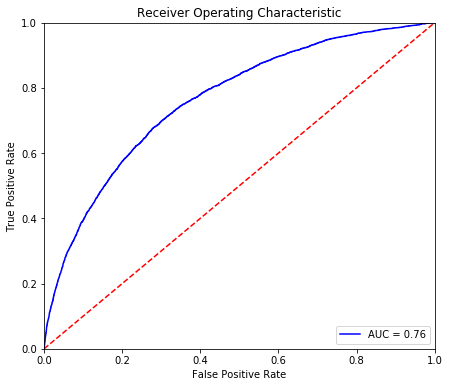

In [41]:
fig = plt.figure(figsize=(7,6))
y_pred_proba = logistic.predict_proba(X_test_best)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba, pos_label = 1)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
#plt.plot(fpr,tpr,label="data, auc="+str(auc))
#plt.legend(loc=4)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.show()

In [42]:
aucs['Logistic Regression'] = auc

In [43]:
auc

0.7631563305425489

### Random Forest

In [44]:
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=200, random_state=0, n_jobs=-1, max_depth = 10)

# Train the classifier
clf.fit(X_train_sel, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [46]:
# Print the name and gini importance of each feature
for feature in zip(features_sel, clf.feature_importances_):
    print(feature)

('CREDIT_DIV_ANNUITY', 0.01159678956013281)
('EXT_SOURCE_1', 0.02974172583900734)
('EXT_SOURCE_2', 0.09835966170632286)
('EXT_SOURCE_3', 0.08411000081527162)
('DAYS_BIRTH', 0.01633814707108545)
('CREDIT_MINUS_GOOD', 0.02018364590959535)
('DAYS_EMPLOYED', 0.024373220441428103)
('AMT_ANNUITY', 0.005446851259038108)
('ins_PAYMENT_DIFF', 0.009693824019722928)
('POS_CNT_INSTALMENT_FUTURE', 0.0071484773182009876)
('ANNUITY_INCOME_PERCENT', 0.0081921954253868)
('DAYS_ID_PUBLISH', 0.008013110438693644)
('BUR_AMT_CREDIT_SUM_DEBT', 0.0016165165434385684)
('app_CNT_PAYMENT', 0.006176734610371696)
('app_AMT_ANNUITY', 0.005943885761654782)
('POS_prev_pos_count', 0.00645861043142907)
('AMT_CREDIT', 0.0023854767503309524)
('AMT_GOODS_PRICE', 0.002317511129548847)
('ins_DBD', 0.006717353980560119)
('DAYS_LAST_PHONE_CHANGE', 0.008109198923297945)
('DAYS_REGISTRATION', 0.006687673599570697)
('app_AMT_DOWN_PAYMENT', 0.004428239222739186)
('BUR_AMT_CREDIT_MAX_OVERDUE', 0.0011629698066792436)
('BIRTH_DIV_E

In [49]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 
sfm = SelectFromModel(clf, threshold=0.005)

# Train the selector
sfm.fit(X_train_sel, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='gini', max_depth=10,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=200, n_jobs=-1,
                                                 oob_score=False,
                                                 random_state=0, verbose=0,
                                                 warm_star

In [51]:
# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(features_sel[feature_list_index])

CREDIT_DIV_ANNUITY
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
DAYS_BIRTH
CREDIT_MINUS_GOOD
DAYS_EMPLOYED
AMT_ANNUITY
ins_PAYMENT_DIFF
POS_CNT_INSTALMENT_FUTURE
ANNUITY_INCOME_PERCENT
DAYS_ID_PUBLISH
app_CNT_PAYMENT
app_AMT_ANNUITY
POS_prev_pos_count
ins_DBD
DAYS_LAST_PHONE_CHANGE
DAYS_REGISTRATION
BIRTH_DIV_EMPLOYED
ins_CNT_DRAWINGS_ATM_CURRENT
REGION_POPULATION_RELATIVE
ins_AMT_PAYMENT
BUR_DAYS_CREDIT_ENDDATE
BUR_Loan_FRQ
BUR_DAYS_CREDIT
app_NAME_CONTRACT_STATUS_Refused
ins_NUM_INSTALMENT_NUMBER
ins_ins_count
ins_PAYMENT_PERC
app_HOUR_APPR_PROCESS_START
POS_SK_DPD_DEF
app_NAME_YIELD_GROUP_high
POS_MONTHS_BALANCE
DAYREG_DIV_DAYPUB
BUR_CREDIT_ACTIVE_Closed
BUR_PLoan_num
app_DAYS_DECISION
BUR_DAYS_ENDDATE_FACT
ins_DAYS_ENTRY_PAYMENT
ins_CNT_DRAWINGS_CURRENT
NAME_EDUCATION_TYPE_Higher education
INTEREST_RATE
INTEREST_SHARE
ins_AMT_INSTALMENT
ins_DAYS_INSTALMENT
BUR_CREDIT_TYPE_Microloan
BUR_DAYS_CREDIT_UPDATE
POS_CNT_INSTALMENT
POS_SK_DPD
BUR_CREDIT_ACTIVE_Active
ins_AMT_DRAWINGS_ATM_CURRENT


In [52]:
# Transform the data to create a new dataset containing only the most important features
X_important_train = sfm.transform(X_train_sel)
X_important_test = sfm.transform(X_test_sel)

In [53]:
# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=200, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [55]:
# Apply The Full Featured Classifier To The Test Data
y_pred = clf.predict(X_test_sel)

# View The Accuracy, Precision and Recall Of our model with all features
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, pos_label = 1))
print("Recall:",metrics.recall_score(y_test, y_pred, pos_label = 1))

Accuracy: 0.9192663732737876
Precision: 0.0
Recall: 0.0


C:\Users\Notebook HP\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<Figure size 576x576 with 0 Axes>

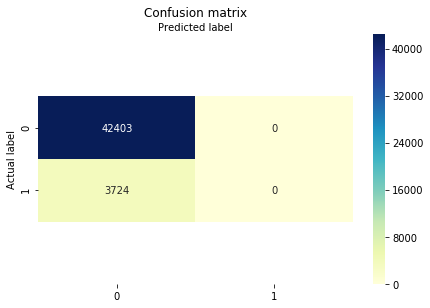

In [59]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
heat_conf(conf_matrix)

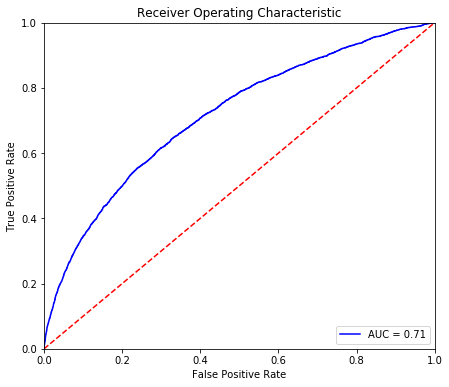

In [65]:
fig = plt.figure(figsize=(7,6))
y_pred_proba = clf.predict_proba(X_test_sel)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba, pos_label = 1)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
#plt.plot(fpr,tpr,label="data, auc="+str(auc))
#plt.legend(loc=4)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.show()

In [68]:
aucs['Random Forest'] = auc
auc

0.7144069551753591

In [56]:
# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy,Precision and Recall off our model with selected features
print("Accuracy:",metrics.accuracy_score(y_test, y_important_pred))
print("Precision:",metrics.precision_score(y_test, y_important_pred, pos_label = 1))
print("Recall:",metrics.recall_score(y_test, y_important_pred, pos_label = 1))

Accuracy: 0.9099009257051185
Precision: 0.27263157894736845
Recall: 0.06954887218045112


<Figure size 576x576 with 0 Axes>

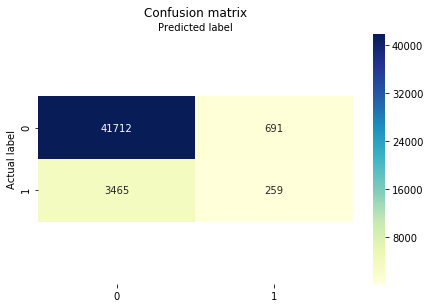

In [58]:
conf_matrix = metrics.confusion_matrix(y_test, y_important_pred)
heat_conf(conf_matrix)

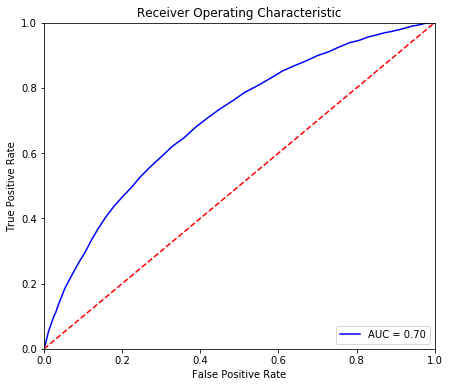

In [69]:
fig = plt.figure(figsize=(7,6))
y_pred_proba = clf_important.predict_proba(X_important_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba, pos_label = 1)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
#plt.plot(fpr,tpr,label="data, auc="+str(auc))
#plt.legend(loc=4)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.show()

In [70]:
aucs['Random Forest selected'] = auc
auc

0.7008113520127939

### Light gbm

In [72]:
# Defining again the dataframes, without scaling
X_train_sel = X_train[features_sel]
X_val_sel = X_val[features_sel]
X_test_sel = X_test[features_sel]

Since the dataset is unbalanced, with over 90% of target values equal to 0, we need to add weight to give more importance to the target value 1 when is found. (We tried downsampling, but it didn't give better results).

In [73]:
tar_weight = np.ones((len(X_train_sel),), dtype=int)
for i in range(len(X_train_sel)):
    if y_train[i]== 0:
        tar_weight[i]=1
    else:
        tar_weight[i]=10

In [102]:
# lgbm format
train = lgb.Dataset(X_train_sel, label = y_train, weight= tar_weight )
valid = lgb.Dataset(X_val_sel, label = y_val)

Cross Validation to find the best max depth:

In [106]:
cross = []
max_D = [2,3,5,10] # Possible values of max_depth parameter

for i in max_D:
    params = {'boosting_type': 'gbdt',
          'max_depth' : i,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 32,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 0.7,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 20,
          'reg_lambda': 20,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 10,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'auc'
          }
    lgbm = lgb.train(params,
                 train,
                 2500,
                 valid_sets=valid,
                 early_stopping_rounds= 100,
                 verbose_eval= 10
                 )
    y_prob = lgbm.predict(X_val_sel)
    cross.append(roc_auc_score(y_val,y_prob))
best = max_D[np.argmax(cross)]
print('The best max depth is ', best )

Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.702735
[20]	valid_0's auc: 0.710412
[30]	valid_0's auc: 0.71951
[40]	valid_0's auc: 0.727887
[50]	valid_0's auc: 0.733787
[60]	valid_0's auc: 0.738278
[70]	valid_0's auc: 0.741711
[80]	valid_0's auc: 0.74422
[90]	valid_0's auc: 0.7471
[100]	valid_0's auc: 0.74932
[110]	valid_0's auc: 0.751555
[120]	valid_0's auc: 0.753255
[130]	valid_0's auc: 0.755201
[140]	valid_0's auc: 0.756798
[150]	valid_0's auc: 0.758295
[160]	valid_0's auc: 0.759791
[170]	valid_0's auc: 0.760693
[180]	valid_0's auc: 0.761579
[190]	valid_0's auc: 0.762433
[200]	valid_0's auc: 0.763228
[210]	valid_0's auc: 0.764104
[220]	valid_0's auc: 0.764776
[230]	valid_0's auc: 0.765399
[240]	valid_0's auc: 0.766078
[250]	valid_0's auc: 0.766616
[260]	valid_0's auc: 0.76721
[270]	valid_0's auc: 0.767679
[280]	valid_0's auc: 0.768289
[290]	valid_0's auc: 0.768657
[300]	valid_0's auc: 0.769134
[310]	valid_0's auc: 0.769601
[320]	valid_0's auc: 0.

In [107]:
params = {'boosting_type': 'gbdt',
          'max_depth' : 5,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 32,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 0.7,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 20,
          'reg_lambda': 20,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 10,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'auc'
          }
lgbm = lgb.train(params,
                 train,
                 2500,
                 valid_sets=valid,
                 early_stopping_rounds= 100,
                 verbose_eval= 10
                 )

Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.731249
[20]	valid_0's auc: 0.738782
[30]	valid_0's auc: 0.744702
[40]	valid_0's auc: 0.751484
[50]	valid_0's auc: 0.7561
[60]	valid_0's auc: 0.760151
[70]	valid_0's auc: 0.763206
[80]	valid_0's auc: 0.765448
[90]	valid_0's auc: 0.767182
[100]	valid_0's auc: 0.768764
[110]	valid_0's auc: 0.770068
[120]	valid_0's auc: 0.771389
[130]	valid_0's auc: 0.772248
[140]	valid_0's auc: 0.773328
[150]	valid_0's auc: 0.774247
[160]	valid_0's auc: 0.774851
[170]	valid_0's auc: 0.775483
[180]	valid_0's auc: 0.776014
[190]	valid_0's auc: 0.776567
[200]	valid_0's auc: 0.776978
[210]	valid_0's auc: 0.77746
[220]	valid_0's auc: 0.778103
[230]	valid_0's auc: 0.778562
[240]	valid_0's auc: 0.779051
[250]	valid_0's auc: 0.779454
[260]	valid_0's auc: 0.779785
[270]	valid_0's auc: 0.780073
[280]	valid_0's auc: 0.780317
[290]	valid_0's auc: 0.780565
[300]	valid_0's auc: 0.781104
[310]	valid_0's auc: 0.781273
[320]	valid_0's auc:

In [108]:
y_pred_prob = lgbm.predict(X_test_sel)

In [109]:
y_pred_prob # Probabilities relative to clients

array([0.29220388, 0.13558304, 0.19770325, ..., 0.82145618, 0.21915942,
       0.32094528])

In [110]:
# Giving each predicted probability a target value
y_pred = np.ones((len(X_test_sel),), dtype=int)
for i in range(len(y_pred_prob)):
    if y_pred_prob[i]<=0.5:
        y_pred[i]=0
    else:
        y_pred[i]=1

In [111]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

<Figure size 576x576 with 0 Axes>

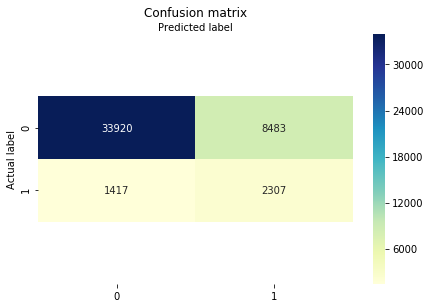

In [112]:
heat_conf(conf_matrix)

In [113]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, pos_label = 1))
print("Recall:",metrics.recall_score(y_test, y_pred, pos_label = 1))

Accuracy: 0.7853751598846662
Precision: 0.21380908248378128
Recall: 0.6194951664876477


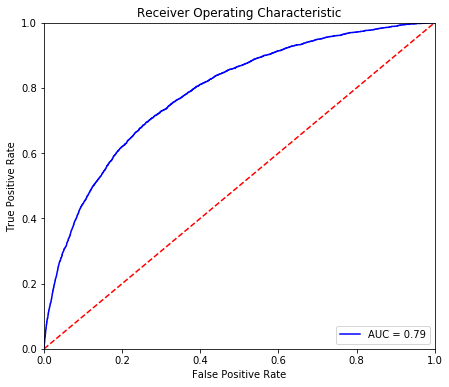

In [114]:
fig = plt.figure(figsize=(7,6))
y_pred_proba = lgbm.predict(X_test_sel)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba, pos_label = 1)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.show()

In [115]:
aucs['Light GBM'] = auc
auc

0.7865643398202097

In [99]:
best_method = max(aucs.items(), key=operator.itemgetter(1))[0]
best_method

'Light GBM'